In [91]:
import importlib
import sys
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from data_prep import DataPrep
from rfi_flagging import RFI_flagging
import helper_functions as hf
from gsm_data import GSMData, get_desired_frequencies

In [147]:
_ = importlib.reload(sys.modules['gsm_data'])
from gsm_data import GSMData, get_desired_frequencies

In [143]:
instrument = '70MHz'
channel = 'EW'
year = '2021'

In [123]:
# horizon profile
if instrument == '70MHz':
    SHAPES = np.load('PRIZM_70MHz_height_horizon.npz')
elif instrument == '100MHz':
    SHAPES = np.load('PRIZM_100MHz_height_horizon.npz')
    
profile, az = SHAPES['profile'], SHAPES['azimuth']

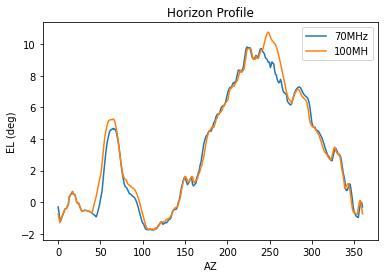

In [109]:
plt.title('Horizon Profile')
plt.xlabel('AZ')
plt.ylabel('EL (deg)')
plt.plot(az, profile, label='70MHz')
plt.plot(az, profile100, label='100MH')
plt.legend()

In [148]:
minperbin=10

if instrument == '70MHz':
    incline_S = 2.25 # recorded 2-2.5
    incline_E = -1.5
    site_latitude = -49.88714
elif instrument == '100MHz':
    incline_S = 1.5
    incline_E = -2.5
    site_latitude = -49.88722

gsm = GSMData(instrument, channel, minperbin, horizon=profile, incline_S=incline_S, incline_E=incline_E, ant_orientation=0, site_latitude=site_latitude)

In [78]:
beam_dict = gsm.beam_dict
healpy_beam = gsm.healpy_beam 
healpy_horizon = gsm.healpy_horizon

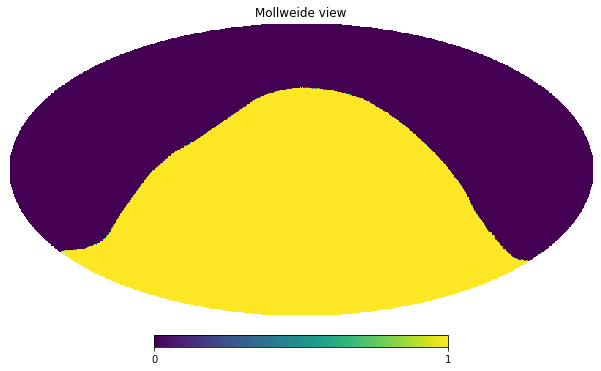

In [62]:
hp.mollview(healpy_horizon)

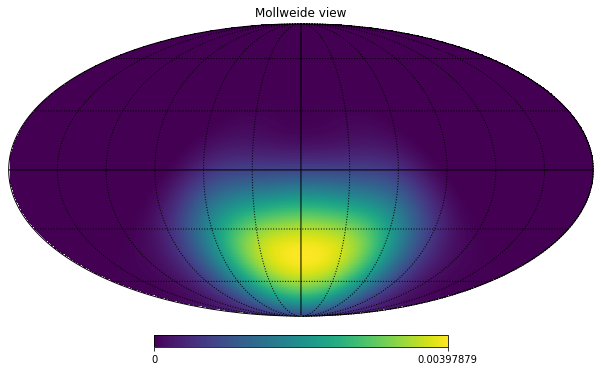

In [79]:
f = 60
hp.mollview(healpy_beam[f])
hp.graticule()

In [161]:
Tgsm_nohor = np.load('GSM_averages/100MHz_NS_GSM_average_2minbins_0align.npy')
Tgsm = np.load('GSM_averages/100MHz_NS_GSM_average_2minbins_horizon_0align.npy')

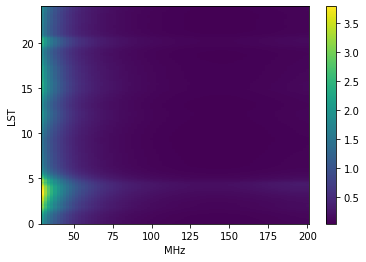

In [143]:
plt.xlabel('MHz')
plt.ylabel('LST')
plt.pcolormesh(np.arange(30,202,2), np.linspace(0,24,720), Tgsm_nohor - Tgsm, shading='nearest')
plt.colorbar()

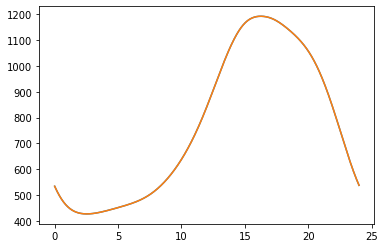

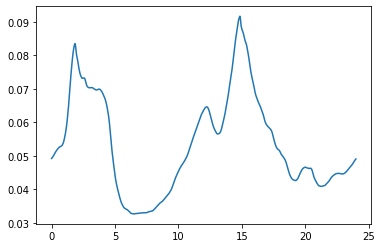

In [162]:
f = 70
plt.plot(np.linspace(0,24,720), Tgsm_nohor[:,f-25])
plt.plot(np.linspace(0,24,720), Tgsm[:,f-25])
plt.show()

plt.plot(np.linspace(0,24,720), Tgsm_nohor[:,f-25] - Tgsm[:, f-25])

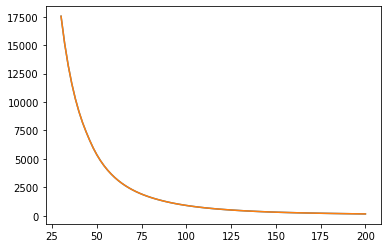

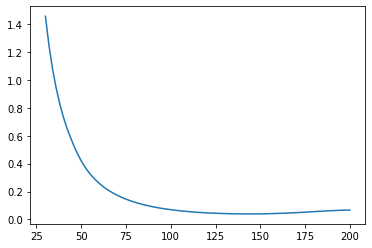

In [142]:
t = 240 # 25
plt.plot(np.arange(30,202,2), Tgsm_nohor[t])
plt.plot(np.arange(30,202,2), Tgsm[t])
plt.show()

plt.plot(np.arange(30,202,2), Tgsm_nohor[t] - Tgsm[t])

### Beam Comparison (PRIZM, MIST, SHAPES case study)

#### SHAPES case study

In [24]:
def alpha(nu):
    return 115 - 0.3 * nu + 0.001 * nu**2

def B(nu, theta):
    return np.exp(-4 * np.log(2) * (theta / alpha(nu))**2)

In [131]:
X,Y = np.meshgrid(np.arange(30,202,2), np.arange(0,90))

In [132]:
SHAPES_beam = B(X, Y)

#### MIST

In [133]:
FEKO_beam = np.load('../../MIST/Data/FEKO_beam_data_rot76.npz')
FEKO_rad_eff = np.load('../../MIST/Data/FEKO_rad_eff.npz')

gain = FEKO_beam['gain']
AZ = FEKO_beam['AZ']
EL = FEKO_beam['EL']

eff = FEKO_rad_eff['eff']

beam = gain / (eff[:,None,None]/100)

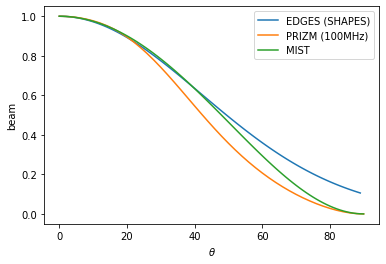

In [135]:
f = 70
t=150
plt.ylabel('beam')
plt.xlabel(r'$\theta$')
plt.plot(range(0,90), SHAPES_beam[:,(f-30) // 2], label='EDGES (SHAPES)')
plt.plot(beam_dict['theta']*180/np.pi, 10**(beam_dict[f][t//2] / 10) / np.max(10**(beam_dict[f][t] / 10)), label='PRIZM (100MHz)')
plt.plot(90-EL, beam[f-25,:, t]/np.max(beam[f-25,:, t]), label='MIST')
plt.legend()

In [1]:
import numpy as np

In [3]:
instrument = '100MHz'

dir_parent='./Beams'
if instrument == '100MHz':
    file_name='results_pattern_100mhz_total90.dat'

if instrument == '70MHz':
    file_name='results_pattern_70mhz_total90.dat'

# Initializes the dictionary which will hold the beam information.
beam_dict = {}

# Establishes the `file_path` which points to the beam simulation of interest.
file_path = dir_parent + '/' + file_name

# Stores the beam simulation data in the NumPy array `beam_sim_data`, and
# ignores the header as a comment starting with '#'.
beam_sim_data = np.loadtxt(file_path, delimiter=',', comments='#')

# Reads the beam file header, cleans it from unwanted characters, and keeps
# only the numerical entries - these correspond to the different frequencies
# for which the beam has been simulated.
beam_file = open(file_path, 'r')
header = beam_file.readline()
frequencies = header.strip('#\n, ').split(',')[2:]
beam_file.close()

In [4]:
# Converts the `frequencies` list to a NumPy array and converts its values
# to MHz through a division by 1e6.
frequencies = np.asarray(frequencies, dtype='float') / 1e6

In [6]:
# Extracts the spherial coordinates `theta` and `phi` stored in
# `beam_sim_data` and converts their units from degrees to radians.
theta = np.unique(beam_sim_data[:, 0]) * np.pi / 180
phi = np.unique(beam_sim_data[:, 1]) * np.pi / 180

In [10]:
# Discards the coordinate information from `beam_sim_data` since this is
# already stored in the meshgrid, as well as in `theta` and `phi`.
beam_sim_data = beam_sim_data[:, 2:]

In [49]:
index = 0
reshaped_beam_sim = np.reshape(beam_sim_data[:, index], [len(phi), len(theta)])

In [50]:
reshaped_beam_sim = np.concatenate((reshaped_beam_sim[45:-1], reshaped_beam_sim[:45], reshaped_beam_sim[45,None]), axis=0)

In [ ]:


# Stores spherical coordinates in `beam_dict`.
beam_dict['theta'] = theta
beam_dict['phi'] = phi

# Stores the beam profile for each frequency in `beam_dict`.
for index, entry in enumerate(frequencies):
    # Reshape the `beam_sim_data` so that its dimensions are compatible with
    # those of `theta` and `phi`. This way different slices of `beam_sim_data`
    # correspond to the beam for different frequencies.
    reshaped_beam_sim = np.reshape(beam_sim_data[:, index],
                                   [len(phi), len(theta)])

    if channel == 'NS':
        reshaped_beam_sim = reshaped_beam_sim[-90:]

    # Stores the reshaped beam in `beam_dict` under the appropriate
    # frequency key.
    beam_dict[entry] = reshaped_beam_sim